This notebook runs the statistical tests for the ligand-binding region of NOTCH1 in normal skin using a variety of assumptions to build the mutational spectrum for the null model. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8, 6]

In [2]:
from darwinian_shift import DarwinianShift, GlobalKmerSpectrum, TranscriptKmerSpectrum, EvenMutationalSpectrum
from darwinian_shift import CDFMonteCarloTest, BinomTest
from darwinian_shift import FoldXLookup, SequenceDistanceLookup, MutationExclusionLookup, StructureDistanceLookup
from darwinian_shift import MutationExclusionLookup, ORLookup
from darwinian_shift import hide_top_and_right_axes

/Users/mh28/miniconda3/envs/dsenv3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mh28/miniconda3/envs/dsenv3/lib/python3.8/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


# Setup

In [3]:
# Define the region to test
notch1_section_definition_egf11_12 = {
    'transcript_id': 'ENST00000277541', 'pdb_id': '2vj3', 'pdb_chain': 'A', 
    'start': 412, 'end': 488, # Restrict to the residues in EGF11-12
    'interface_residues': [413, 415, 418, 420, 421, 422, 423, 424, 425, 
                         435, 436, 444, 447, 448, 450, 451, 452, 454, 
                         466, 467, 468, 469, 470, 471, 475, 477, 478, 
                         479, 480],   # defined in Luca et al 2017
    'ca_binding_residues': [412, 413, 415, 431, 432, 435, 452, 453, 455, 469, 470]  # Defined by MetalPDB
}

In [4]:
# Directories
sifts_directory="SIFTS_files"
pdb_directory = "PDB_files"

# Colours
unobserved_colour = '#BBBBBB'  
observed_colour = '#EE7733'
foldx_expected_colour = '#EE6677'
foldx_observed_colour = '#CC3311'
interface_expected_colour = '#88CCEE'
interface_observed_colour = '#0077BB'
calcium_expected_colour = '#8DE0D7'
calcium_observed_colour = '#009988'

# Define the metrics

## Individual metrics

In [5]:
# Define the FoldX lookup
fold = FoldXLookup(foldx_results_directory="FoldX_results",
                   sifts_directory=sifts_directory,
                   foldx_file_name_start="PS_f*", download_sifts=True)

In [6]:
# Define a lookup object which determines whether mutations are on the NOTCH1-ligand interface. 
interface_lookup = SequenceDistanceLookup(
    boolean=True,   # Just a boolean on/off interface. 
    target_key='interface_residues',   # Use this entry in the section_definition dict to define the target residues
    position_type='residue',   # Use the residue number (as opposed to cdspos or chromosomal position)
    name='On interface'  # Label to appear on plot axes
)

In [7]:
ca_lookup = SequenceDistanceLookup(
    boolean=True,   # Just a boolean binding/not binding. 
    target_key='ca_binding_residues',   # Use this entry in the section_definition dict to define the target residues
    position_type='residue',   # Use the residue number (as opposed to cdspos or chromosomal position)
    name='Calcium binding'  # Label to appear on plot axes
)

## Conditional tests 

In [8]:
# First define a lookup that is 1 if the mutation is on the interface and or calcium binding
interface_or_ca_lookup = ORLookup(
    lookups=[interface_lookup, ca_lookup],  
    thresholds=[0.5, 0.5],  # Set thresholds at 0.5
    directions=[1, 1],  # Want to exclude mutations which score 1 for interface or calcium binding.
)


# Define the combined lookup.
excllook_foldx = MutationExclusionLookup(
    lookup=fold,   # Use the calcium binding lookup for the test
    exclusion_lookup=interface_or_ca_lookup,
    exclusion_threshold=0.5,  #  Scores from the exclusion are either 0, or 1, so can put threshold anywhere in between.
    exclusion_direction=1,   # Exclude mutations with a score above the exclusion_threhold from the exclusion_lookup.
    name=fold.name
)

In [9]:
# Define a lookup to test the interface while excluding destabilising mutations. 
excllook_interface_foldx_only = MutationExclusionLookup(
    lookup=interface_lookup,   # Use the interface lookup for the test
    exclusion_lookup=fold,   
    exclusion_threshold=2,  #  Exclude mutations with ∆∆G higher than 2kcal/mol.
    exclusion_direction=1,   # Exclude mutations with a score above the exclusion_threhold from the exclusion_lookup.
    name=interface_lookup.name
)

In [10]:
# First define a lookup that is 1 if the mutation is destabilising or calcium binding
destabilising_or_ca_lookup = ORLookup(
    lookups=[fold, ca_lookup],  
    thresholds=[2, 0.5],  # Use 2kcal/mol as the ∆∆G threshold. Ca score is 0 or 1, so set threshold at 0.5
    directions=[1, 1],  # Want to exclude mutations which score 1 for calcium binding or > 2 for ∆G.
)


# Define the combined lookup.
excllook_interface = MutationExclusionLookup(
    lookup=interface_lookup,   # Use the inteface lookup for the test
    exclusion_lookup=destabilising_or_ca_lookup,   
    exclusion_threshold=0.5,  #  Scores from the exclusion are either 0, or 1, so can put threshold anywhere in between.
    exclusion_direction=1,   # Exclude mutations with a score above the exclusion_threhold from the exclusion_lookup.
    name=interface_lookup.name
)

In [11]:
# First define a lookup that is 1 if the mutation is destabilising or on the interface and 0 otherwise.
destabilising_or_interface_lookup = ORLookup(
    lookups=[fold, interface_lookup],  # Use the FoldX and the interface lookups.  
    thresholds=[2, 0.5],  # Again pick a threshold of 2kcal/mol for the FoldX result, interface results are either 0 or 1 so set threshold at 0.5. 
    directions=[1, 1],  # Want to exclude mutations with scores greater than the thresholds, so directions are both 1.
)


# Define the combined lookup.
excllook_ca = MutationExclusionLookup(
    lookup=ca_lookup,   # Use the calcium binding lookup for the test
    exclusion_lookup=destabilising_or_interface_lookup,   
    exclusion_threshold=0.5,  #  Scores from the exclusion are either 0, or 1, so can put threshold anywhere in between.
    exclusion_direction=1,   # Exclude mutations with a score above the exclusion_threhold from the exclusion_lookup.
    name=ca_lookup.name
)

# Alternative mutational spectra

## Skin

In [12]:
# Create a list of all the spectra needed. 
supp_fig_spectra = [EvenMutationalSpectrum()]
for glob in [1, 0]: # Global or per transcript spectrum
    for k in [1, 3, 5]:  # Nucleotide context. No wider context, trinucleotide and pentanucleotide
        for ignore_strand in [1, 0]:  # Combine transcribed/non-transcribed strand or not
            for deduplicate_spectrum in [0, 1]:  # Don't/do remove duplicate mutations as these may be positively selected
                num_rates = 6*4**(k-1)
                if not ignore_strand:
                    num_rates *= 2
                if deduplicate_spectrum:
                    dedup = '_dedup'
                else:
                    dedup = ''
                
                if glob:
                    # Add a global spectrum (all genes assumed to have the same spectrum)
                    spec = GlobalKmerSpectrum(
                        k=k, ignore_strand=ignore_strand, deduplicate_spectrum=deduplicate_spectrum, 
                        # Spectra need unique names for creation of dataframe columns
                        name='global_{}{}'.format(num_rates, dedup) 
                    )
                    supp_fig_spectra.append(spec)
                else:
                    # Add transcript spectrum (all transcripts assumed to have their own unique spectrum)
                    spec = TranscriptKmerSpectrum(
                        k=k, ignore_strand=ignore_strand, deduplicate_spectrum=deduplicate_spectrum, 
                        # Spectra need unique names for creation of dataframe columns
                        name='transcript_{}{}'.format(num_rates, dedup)
                    )
                    supp_fig_spectra.append(spec)


In [13]:
# This will take a long time because of the multiple spectra that have to be calculated
d_skin = DarwinianShift(
    data = pd.read_excel('248092_3_supp_6645104_q35h43.xlsx', sheet_name='Table S4', skiprows=4),
    source_genome='GRCh37',
    spectra=supp_fig_spectra,
    included_mutation_types='missense'
)

In [14]:
spectra_colours = []
for spectrum in supp_fig_spectra:
    if isinstance(spectrum, EvenMutationalSpectrum):
        spectra_colours.append('k')
    elif isinstance(spectrum, GlobalKmerSpectrum):
        spectra_colours.append('#bdbdbd')
    elif isinstance(spectrum, TranscriptKmerSpectrum):
        spectra_colours.append('#636363')

### FoldX

In [15]:
s_fold_specta = d_skin.run_section(notch1_section_definition_egf11_12, lookup=excllook_foldx, 
                                         statistics=CDFMonteCarloTest(num_draws=100000))

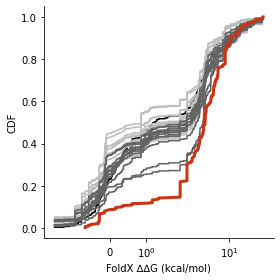

In [16]:
s_fold_specta.plot_cdfs(figsize=(4, 4), plot_scale='symlog', show_legend=False,
                       colours=[foldx_observed_colour] + spectra_colours)
hide_top_and_right_axes()
plt.tight_layout()

In [17]:
fold_spectra_res = s_fold_specta.get_results_dictionary()

### Interface

In [18]:
# This excludes mutationsn with ∆∆G > 2kcal/mol
s_interface_spectra = d_skin.run_section(notch1_section_definition_egf11_12, lookup=excllook_interface, 
                                               statistics=BinomTest())

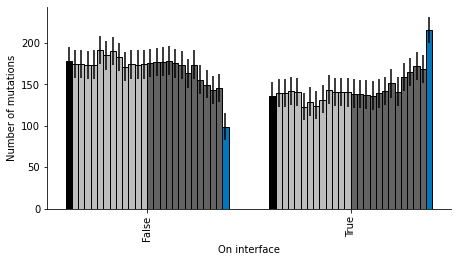

In [19]:
s_interface_spectra.plot_binned_counts(
    figsize=(8, 4), show_legend=False,
    colours=[interface_observed_colour] + spectra_colours,
    linewidth=1 
)
hide_top_and_right_axes()
plt.title('')
plt.xticks(plt.gca().get_xticks(), ['False', 'True'])
plt.xlabel('On interface')
plt.subplots_adjust(left=0.3, bottom=0.3, right=1, top=1)

In [20]:
interface_spectra_res = s_interface_spectra.get_results_dictionary()

### Calcium binding

In [21]:
# This excludes mutationsn with ∆∆G > 2kcal/mol and on the ligand-binding interface
s_calcium_spectra = d_skin.run_section(notch1_section_definition_egf11_12,  lookup=excllook_ca, 
                                             statistics=BinomTest())

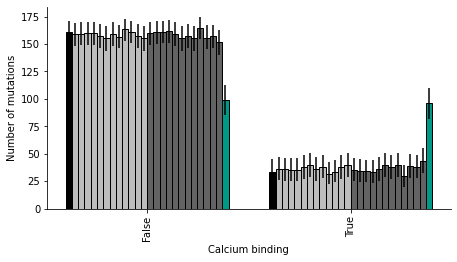

In [22]:
s_calcium_spectra.plot_binned_counts(
    figsize=(8, 4), show_legend=False, 
    colours=[calcium_observed_colour] + spectra_colours,
    linewidth=1
)
hide_top_and_right_axes()
plt.title('')
plt.xticks(plt.gca().get_xticks(), ['False', 'True'])
plt.xlabel('Calcium binding')
plt.subplots_adjust(left=0.3, bottom=0.3, right=1, top=1)

In [23]:
calcium_spectra_res = s_calcium_spectra.get_results_dictionary()

### Alternative spectra pvalues

In [24]:
calcium_spectra_res['feature'] = 'CA'
interface_spectra_res['feature'] = 'interface'
fold_spectra_res['feature'] = 'FoldX'

In [25]:
pd.DataFrame([fold_spectra_res, interface_spectra_res, calcium_spectra_res])

,gene,transcript_id,chrom,section_id,num_mutations,observed_median,observed_mean,expected_median_EvenMutationalSpectrum,median_shift_EvenMutationalSpectrum,expected_mean_EvenMutationalSpectrum,...,binom_transcript_3072_dedup_pvalue,binom_transcript_3072_dedup_expected_proportion,binom_transcript_3072_dedup_observed_proportion,binom_transcript_3072_dedup_expected_count,binom_transcript_3072_dedup_observed_count,binom_transcript_3072_dedup_threshold,binom_transcript_3072_dedup_expected_CI_high,binom_transcript_3072_dedup_expected_CI_low,binom_transcript_3072_dedup_observed_CI_low,binom_transcript_3072_dedup_observed_CI_high
0,NOTCH1,ENST00000277541,9,2vj3:A,452,4.31605,5.585752,1.209925,3.106125,3.409786,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NOTCH1,ENST00000277541,9,2vj3:A,315,1.00000,0.685714,0.000000,1.000000,0.433333,...,8.829355e-08,0.536383,0.685714,168.960573,216.0,0.5,186.0,152.0,199.0,232.0
2,NOTCH1,ENST00000277541,9,2vj3:A,195,0.00000,0.492308,0.000000,0.000000,0.172973,...,1.101765e-16,0.221297,0.492308,43.152871,96.0,0.5,55.0,32.0,82.0,109.0


## Oesophagus

In [26]:
# Create a list of all the spectra needed. 
supp_fig_spectra = [EvenMutationalSpectrum()]
for glob in [1, 0]: # Global or per transcript spectrum
    for k in [1, 3, 5]:  # Nucleotide context. No wider context, trinucleotide and pentanucleotide
        for ignore_strand in [1, 0]:  # Combine transcribed/non-transcribed strand or not
            for deduplicate_spectrum in [0, 1]:  # Don't/do remove duplicate mutations as these may be positively selected
                num_rates = 6*4**(k-1)
                if not ignore_strand:
                    num_rates *= 2
                if deduplicate_spectrum:
                    dedup = '_dedup'
                else:
                    dedup = ''
                
                if glob:
                    # Add a global spectrum (all genes assumed to have the same spectrum)
                    spec = GlobalKmerSpectrum(
                        k=k, ignore_strand=ignore_strand, deduplicate_spectrum=deduplicate_spectrum, 
                        # Spectra need unique names for creation of dataframe columns
                        name='global_{}{}'.format(num_rates, dedup) 
                    )
                    supp_fig_spectra.append(spec)
                else:
                    # Add transcript spectrum (all transcripts assumed to have their own unique spectrum)
                    spec = TranscriptKmerSpectrum(
                        k=k, ignore_strand=ignore_strand, deduplicate_spectrum=deduplicate_spectrum, 
                        # Spectra need unique names for creation of dataframe columns
                        name='transcript_{}{}'.format(num_rates, dedup)
                    )
                    supp_fig_spectra.append(spec)

In [27]:
d_oe = DarwinianShift(
    data=pd.read_excel('aau3879_TableS2.xlsx',
                       sheet_name='Mutations_collapsed_by_distance', skiprows=17),
    source_genome='GRCh37',
    spectra=supp_fig_spectra,
    included_mutation_types='missense'
)

### FoldX

In [28]:
s_fold_specta = d_oe.run_section(notch1_section_definition_egf11_12, lookup=excllook_foldx, 
                                         statistics=CDFMonteCarloTest(num_draws=100000))

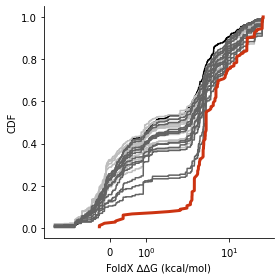

In [29]:
s_fold_specta.plot_cdfs(figsize=(4, 4), plot_scale='symlog', show_legend=False,
                       colours=[foldx_observed_colour] + spectra_colours)
hide_top_and_right_axes()
plt.tight_layout()

In [30]:
fold_spectra_res = s_fold_specta.get_results_dictionary()

### Interface

In [31]:
s_interface_spectra = d_oe.run_section(notch1_section_definition_egf11_12, lookup=excllook_interface, 
                                               statistics=BinomTest())

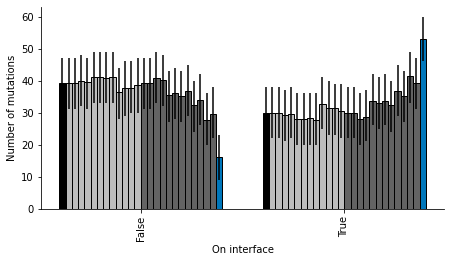

In [32]:
s_interface_spectra.plot_binned_counts(
    figsize=(8, 4), show_legend=False,
    colours=[interface_observed_colour] + spectra_colours,
    linewidth=1 
)
hide_top_and_right_axes()
plt.title('')
plt.xticks(plt.gca().get_xticks(), ['False', 'True'])
plt.xlabel('On interface')
plt.subplots_adjust(left=0.3, bottom=0.3, right=1, top=1)

In [33]:
interface_spectra_res = s_interface_spectra.get_results_dictionary()

### Calcium binding

In [34]:
s_calcium_spectra = d_oe.run_section(notch1_section_definition_egf11_12,  lookup=excllook_ca, 
                                             statistics=BinomTest())

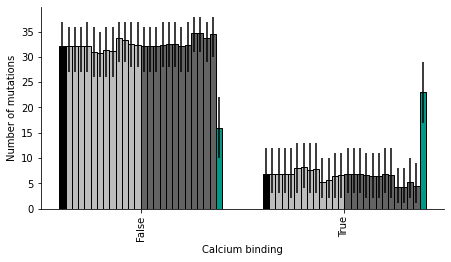

In [35]:
s_calcium_spectra.plot_binned_counts(
    figsize=(8, 4), show_legend=False, 
    colours=[calcium_observed_colour] + spectra_colours,
    linewidth=1
)
hide_top_and_right_axes()
plt.title('')
plt.xticks(plt.gca().get_xticks(), ['False', 'True'])
plt.xlabel('Calcium binding')
plt.subplots_adjust(left=0.3, bottom=0.3, right=1, top=1)

In [36]:
calcium_spectra_res = s_calcium_spectra.get_results_dictionary()

### Alternative spectra pvalues

In [37]:
calcium_spectra_res['feature'] = 'CA'
interface_spectra_res['feature'] = 'interface'
fold_spectra_res['feature'] = 'FoldX'

pd.DataFrame([fold_spectra_res, interface_spectra_res, calcium_spectra_res])

,gene,transcript_id,chrom,section_id,num_mutations,observed_median,observed_mean,expected_median_EvenMutationalSpectrum,median_shift_EvenMutationalSpectrum,expected_mean_EvenMutationalSpectrum,...,binom_transcript_3072_dedup_pvalue,binom_transcript_3072_dedup_expected_proportion,binom_transcript_3072_dedup_observed_proportion,binom_transcript_3072_dedup_expected_count,binom_transcript_3072_dedup_observed_count,binom_transcript_3072_dedup_threshold,binom_transcript_3072_dedup_expected_CI_high,binom_transcript_3072_dedup_expected_CI_low,binom_transcript_3072_dedup_observed_CI_low,binom_transcript_3072_dedup_observed_CI_high
0,NOTCH1,ENST00000277541,9,2vj3:A,181,4.48213,8.343828,1.209925,3.272205,3.409786,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NOTCH1,ENST00000277541,9,2vj3:A,69,1.00000,0.768116,0.000000,1.000000,0.433333,...,8.939091e-04,0.570712,0.768116,39.379143,53.0,0.5,47.0,31.0,46.0,60.0
2,NOTCH1,ENST00000277541,9,2vj3:A,39,1.00000,0.589744,0.000000,1.000000,0.172973,...,1.090641e-12,0.113439,0.589744,4.424113,23.0,0.5,9.0,1.0,17.0,29.0
